##  Chapter 3: Classification

In [18]:
# fetch the MNIST dataset from sklearn
from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [19]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


5


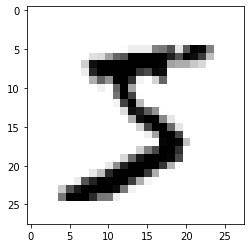

In [20]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap="binary")
print(y[0])

In [21]:
# cast y to integers
y = y.astype(np.uint8)

In [22]:
# split into train and test set (already predetermined in dataset)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

In [23]:
# will classify fives as fives or not-fives
y_train_5 = (y_train == 5)
y_test_5 = (y_test ==5)

In [24]:
from sklearn.linear_model import SGDClassifier

# train stochastic gradient descent classifier to recognize fives
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

## Measuring Accuracy using Cross-Validation

In [26]:
# the below code is used to implement cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [27]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

## Confusion Matrix

In [29]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [30]:
# a perfect confusion matrix would look like the below
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [31]:
# precision = TP / (TP + FP)
# recall = TP / (TP + FN)

from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


In [32]:
# This means that when the classifier claims an image is a 5, it is correct 83.7% of the time
# Similarly, it on;y detectd 65.1% of the fives
# it is common to combine precision and recall into a single metric called the f1 score or harmonic mean
# F1 = 2 / (1 / precision + 1 / recall)

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [50]:
# rather than using the sgd predict function, we can use the decision_function method to get the output
# of the decision function
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [37]:
# for normal SGD, the threshhold for the decision function is 0, so the output makes sense here
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [39]:
# let's try raising the threshold
threshold = 8000
y_some_digit_pred = y_scores > threshold
y_some_digit_pred

array([False])

In [51]:
# how do you decide which threhold to use?
# use cross_val_predict again but specify decision_function rather than predict
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

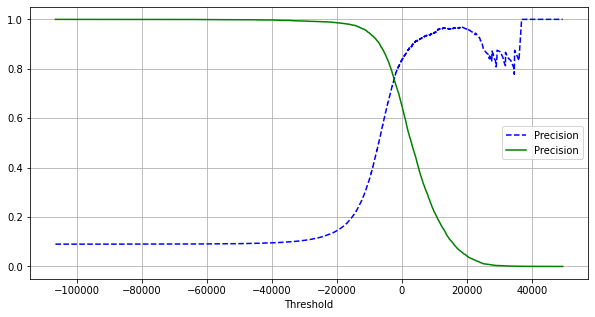

In [60]:
# with these scores, we can use the precision recall curve to compute precision and recall for all thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(10,5))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Precision")
    plt.xlabel("Threshold")
    plt.legend()
    plt.grid(True)
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

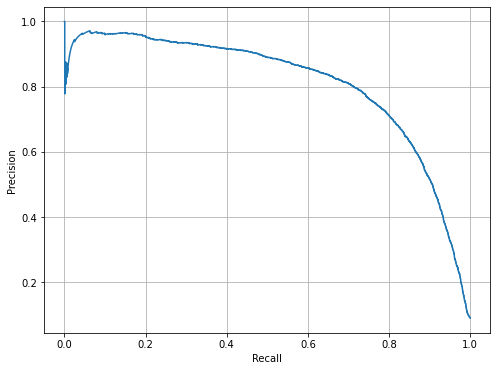

In [62]:
# plot of recall vs precision
plt.figure(figsize=(8,6))
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)

## The ROC Curve

The ROC (receiver operating characteristic) curve plots the true positivity rate (recall) vs the false positivity rate (1 - true negative rate (specificity))

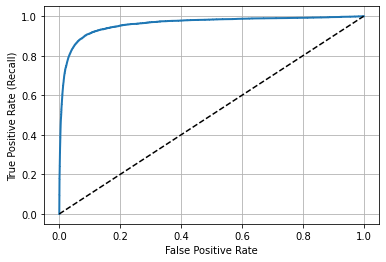

In [71]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--') # Dashed diagonal
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.grid(True)

plot_roc_curve(fpr, tpr, "ROC Curve")
plt.show()

In [67]:
# A perfect classifier will have an area under the curve of the ROC curve of 1
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [68]:
# Now let's plot the ROC curve using a RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [69]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

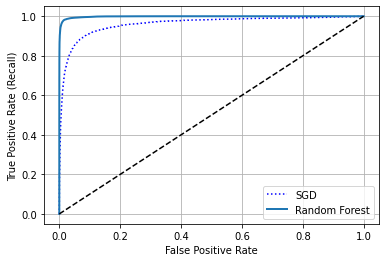

In [72]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [73]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [75]:
# even though SVM's are binary classifiers, sklearn will automatically recognize that you are trying to do a Multiclass
# classification and create the appropriate OvR or OvO model
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [76]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [77]:
# print the max from this array to get the corresponding digit
np.argmax(some_digit_scores)

5

In [78]:
# yay, it is indeed 5
# let's now train an SGD classifier to do the same thing
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [79]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [80]:
np.argmax(some_digit_scores)

3

In [81]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [82]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

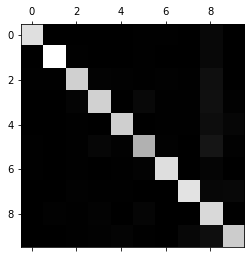

In [83]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

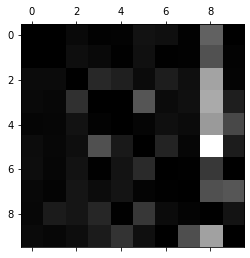

In [84]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()